In [4]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import swiper.plot as plotter
from typing import Any
import scipy
import pandas as pd

In [5]:
directories = ['slurm/data/benchmarks1', 'slurm/data/benchmarks2']
exclude_benchmarks = [[], [], []]

In [6]:
config = []
config_idx_offset = 0
data_by_config = {}
for i,directory in enumerate(directories):
    with open(f'{directory}/config.json', 'r') as f:
        dir_config = json.load(f)
    config.extend(dir_config)
    for file in os.listdir(f'{directory}/output/'):
        print(file)
        with open(f'{directory}/output/{file}', 'r') as f:
            contents = f.read()
            if len(contents) == 0:
                print('Empty file!')
                continue
            data = json.loads(contents)
        config_idx = int(file.split('_')[0][6:])
        if config[config_idx + config_idx_offset]['benchmark_file'].split('/')[-1].split('.')[0] in exclude_benchmarks[i]:
            continue
        data_by_config[config_idx + config_idx_offset] = data
    config_idx_offset = len(config)

# directory = 'slurm/data/20241115_143108'
# with open(f'{directory}/config.json', 'r') as f:
#     config_unlimited = json.load(f)
# data_by_config_unlimited = {}
# for file in os.listdir(f'{directory}/output/'):
#     print(file)
#     with open(f'{directory}/output/{file}', 'r') as f:
#         contents = f.read()
#         if len(contents) == 0:
#             print('Empty file!')
#             continue
#         data = json.loads(contents)
#     config_idx = int(file.split('_')[0][6:])
#     data_by_config_unlimited[config_idx] = data

config115_d21_aligned_None_heisenberg_3_0.json
config106_d27_parallel_None_rz_seq_100_1e-10_0.json
config121_d27_aligned_None_heisenberg_3_0.json
config99_d21_parallel_None_qft_10_0.json
config57_d21_aligned_separate_qft_10_0.json
config91_d15_parallel_None_heisenberg_3_0.json
config58_d21_aligned_separate_rz_seq_100_1e-10_0.json
config84_d21_aligned_separate_qpeexact_10_0.json
config19_d21_sliding_separate_heisenberg_3_0.json
config49_d15_aligned_separate_heisenberg_3_0.json
config96_d21_parallel_None_qpeexact_10_0.json
config24_d15_parallel_separate_qpeexact_10_0.json
config79_d21_parallel_separate_heisenberg_3_0.json
config97_d21_parallel_None_heisenberg_3_0.json
config28_d15_parallel_separate_rz_seq_100_1e-10_0.json
config7_d21_sliding_separate_heisenberg_3_0.json
config108_d15_aligned_None_qpeexact_10_0.json
config88_d21_aligned_separate_rz_seq_100_1e-10_0.json
config85_d21_aligned_separate_heisenberg_3_0.json
config100_d21_parallel_None_rz_seq_100_1e-10_0.json
config3_d15_sliding

In [7]:
def benchmark_name(conf):
    return conf['benchmark_file'].split('/')[-1].split('.')[0]

def get_config_idx(config, schedule_name, config_match):
    indices = []
    for idx, conf in enumerate(config):
        if benchmark_name(conf) == schedule_name and all(conf[k] == v for k, v in config_match.items()):
            indices.append(idx)
    if len(indices) == 1:
        return indices[0]
    else:
        print(f'Found {len(indices)} matches for {schedule_name} and {config_match}: {indices}')
    return None

def get_data(config, data_by_config, schedule_name, config_match):
    config_idx = get_config_idx(config, schedule_name, config_match)
    if config_idx is None:
        return None
    return data_by_config[config_idx]

In [8]:
hatches = ['', '//', '/////', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

In [9]:
def to_str(key_name, key_val):
    if key_name == 'scheduling_method':
        return key_val
    elif key_name == 'speculation_mode':
        return 'SWIPER' if key_val else 'Default'
    elif key_name == 'benchmark':
        return key_val
    else:
        raise NotImplementedError(f'Unknown key name {key_name}')  

from matplotlib.colors import LinearSegmentedColormap
rename_benchmarks = {'grover_ancilla_5':'grover', 'fermi_hubbard_4_4':'fermi_hubbard', 'H2':'H2_molecule', 'rz_1e-10':'rz', 'qrom_15_15':'qrom', 'carleman_2_4':'carleman', 'adder_n18':'adder_8bit', 'qft_10':'qft', 'qpeexact_10':'qpe', 'fermi_hubbard_4_4_Square':'fh_square', 'fermi_hubbard_2_2_Kagome':'fh_kagome', 'heisenberg_3': 'heisenberg'}
colors = ['C1', 'C0']
cmaps = [LinearSegmentedColormap.from_list('cmap0', ['white', colors[0]]), LinearSegmentedColormap.from_list('cmap1', ['white', colors[1]])]

def interpolate(color1, color2, alpha):
    return LinearSegmentedColormap.from_list('_', [color1, color2])(alpha)

colors_by_keys = {
    ('parallel', None):'C0',
    ('aligned', None):'C1',
    ('parallel', 'separate'):interpolate('white', 'C0', 1.0),
    ('aligned', 'separate'):interpolate('white', 'C1', 1.0),
    ('sliding', 'separate'):interpolate('white', 'C3', 1.0),
}
hatches_by_keys = {
    ('parallel', None):'',
    ('aligned', None):'',
    ('parallel', 'separate'):'//',
    ('aligned', 'separate'):'///',
    ('sliding', 'separate'):'/////',
}
def plot_data(
        data_by_config,
        config,
        group_by: str,
        group_by_2: str,
        filter_dict: dict[str, Any] = {},
        relative_to: dict[str, Any] | None = None,
        compare_filter_dict: dict[str, Any] = {},
        sorted_keys: list[str] = [],
        sorted_keys_2: list[str] = [],
        sorted_benchmarks: list[str] = [],
        custom_plot_val: tuple[str, str] = ('device_data', 'num_rounds'),
        x_offsets_after: dict[str, float] = {},
        modifiers: dict[str, Any] = {},
        ax = None,
        hidden_benchmarks: list[str] = [],
    ):
    benchmarks = []
    group_keys = []
    group_keys_2 = []
    results = {}
    limited_proc_results = {}
    for key, data in data_by_config.items():
        if not all(config[key][k] == v for k, v in filter_dict.items()):
            continue
        if not data['success']:
            continue
        benchmark = benchmark_name(config[key])
        runtime = data[custom_plot_val[0]][custom_plot_val[1]]
        group_key = config[key][group_by]
        group_key_2 = config[key][group_by_2]
        benchmarks.append(benchmark)
        group_keys.append(group_key)
        group_keys_2.append(group_key_2)

        if data['simulator_params']['max_parallel_processes'] is None:
            results.setdefault((benchmark, group_key, group_key_2), []).append(runtime)  
        else:
            # limited processors
            limited_proc_results.setdefault((benchmark, group_key, group_key_2), []).append(runtime)

    compare_results = {}
    if compare_filter_dict:
        for key, data in data_by_config.items():
            if not all(config[key][k] == v for k, v in compare_filter_dict.items()):
                continue
            if not data['success']:
                continue
            benchmark = benchmark_name(config[key])
            runtime = data[custom_plot_val[0]][custom_plot_val[1]]
            group_key = config[key][group_by]
            group_key_2 = config[key][group_by_2]
            
            compare_results.setdefault((benchmark, group_key, group_key_2), []).append(runtime)
    # TODO: use compare_results

    # Remove those that do not have all data
    expected_num_data = len(set((k,k2) for b,k,k2 in results.keys()))
    for benchmark in set(benchmarks) | set(sorted_benchmarks):
        if len(set((k,k2) for b,k,k2 in results.keys() if b == benchmark)) != expected_num_data:
            print(f'Removing {benchmark} (only {len(set((k,k2) for b,k,k2 in results.keys() if b == benchmark))} data points)')
            benchmarks = [b for b in benchmarks if b != benchmark]
            results = {k:v for k,v in results.items() if k[0] != benchmark}
            compare_results = {k:v for k,v in compare_results.items() if k[0] != benchmark}
            if benchmark in sorted_benchmarks:
                sorted_benchmarks = [b for b in sorted_benchmarks if b != benchmark]

    result_means = {}
    result_stdevs = {}
    for key in results.keys():
        result_means[key] = np.mean(results[key])
        result_stdevs[key] = np.std(results[key]) if len(results[key]) > 1 else 0
    limited_proc_result_means = {}
    limited_proc_result_stdevs = {}
    for key in limited_proc_results.keys():
        limited_proc_result_means[key] = np.mean(limited_proc_results[key])
        limited_proc_result_stdevs[key] = np.std(limited_proc_results[key])
    compare_result_means = {}
    for key in compare_results.keys():
        compare_result_means[key] = np.mean(compare_results[key])

    # sort benchmarks and group keys by average 
    if len(sorted_benchmarks) < len(set(benchmarks)):
        benchmark_avgs = {b:np.mean([r for (bench,_,_),r in result_means.items() if bench == b]) for b in set(benchmarks) if b not in sorted_benchmarks}
        sorted_benchmarks = sorted_benchmarks + sorted(benchmark_avgs, key=lambda k: benchmark_avgs[k])
    sorted_benchmarks = [x for x in sorted_benchmarks if not (x.startswith('memory') or x.startswith('random') or x.startswith('regular') or (x.startswith('rz') and x != 'rz_1e-10'))]
    sorted_benchmarks = [x for x in sorted_benchmarks if x not in hidden_benchmarks]
    if len(sorted_keys) < len(set(group_keys)):
        print(1)
        key_avgs = {k:np.mean([r for (_,key,_),r in result_means.items() if key == k]) for k in set(group_keys)}
        sorted_keys = sorted(key_avgs, key=lambda x: key_avgs[x], reverse=True)
    if len(sorted_keys_2) < len(set(group_keys_2)):
        print(2)
        key_2_avgs = {k:np.mean([r for (_,_,key),r in result_means.items() if key == k]) for k in set(group_keys_2)}
        sorted_keys_2 = sorted(key_2_avgs, key=lambda x: key_2_avgs[x], reverse=True)

    # colors_by_keys = {key:{key2:cmaps[j]((len(sorted_keys_2)-k)/(len(sorted_keys_2))) for k,key2 in enumerate(sorted_keys_2)} for j,key in enumerate(sorted_keys)}

    limited_proc_val_differences = []

    if ax is None:
        fig,ax = plt.subplots(figsize=(9,2))
    
    relative_to_result_means = {}
    x_offset = 0
    centers = []
    for i,benchmark in enumerate(sorted_benchmarks):
        center = i*(len(sorted_keys)+len(sorted_keys_2)+2) + (len(sorted_keys)+len(sorted_keys_2))/2 + x_offset + 1/2
        centers.append(center)
        prev_x = i*(len(sorted_keys)+len(sorted_keys_2)+2) + x_offset
        for j,key in enumerate(sorted_keys):
            for k,key_2 in enumerate(sorted_keys_2):
                failed = False
                prev_x += 1
                try:
                    relative_to_val = result_means[(benchmark, relative_to[group_by], relative_to[group_by_2])] if relative_to is not None else 1
                    result_val = result_means[(benchmark,key,key_2)] / relative_to_val * modifiers.get(benchmark, 1)
                    result_stdev_val = result_stdevs[(benchmark,key,key_2)] / relative_to_val * modifiers.get(benchmark, 1)
                    assert (benchmark,key,key_2) not in relative_to_result_means
                    relative_to_result_means[(benchmark,key,key_2)] = relative_to_val
                    mpl.rcParams['hatch.linewidth'] = 1.0
                    mpl.rcParams['hatch.color'] = 'white'
                except KeyError as e:
                    failed = True
                    prev_x -= 1
                if not failed:
                    ax.bar(prev_x, result_val, yerr=result_stdev_val, edgecolor='k', color=colors_by_keys[(key_2,key)], width=1, hatch=hatches_by_keys[(key_2,key)], label=f'{to_str(group_by, key)} {to_str(group_by_2, key_2)}' if i == 0 else None, zorder=5)

                    if (benchmark,key,key_2) in compare_results:
                        ax.bar(prev_x, result_val, yerr=result_stdev_val, edgecolor='k', color='w', alpha=0.5, width=1, zorder=5.1)
                        compare_val = compare_result_means[(benchmark,key,key_2)] / relative_to_val * modifiers.get(benchmark, 1)
                        # ax.bar(prev_x, compare_val, edgecolor='k', width=1, color='none', zorder=6)
                        ax.bar(prev_x, compare_val, edgecolor='k', color=colors_by_keys[(key_2,key)], width=1, hatch=hatches_by_keys[(key_2,key)], zorder=6)
                    print(f'{benchmark} {key} {key_2}: {result_val} +- {result_stdev_val}')
                
                    if (benchmark,key,key_2) in limited_proc_results and result_stdevs[(benchmark,key,key_2)] > 0:
                        limited_proc_val_differences += [(result - result_means[(benchmark,key,key_2)]) / result_means[(benchmark,key,key_2)] for i,result in enumerate(limited_proc_results[(benchmark,key,key_2)]) if results[(benchmark,key,key_2)][i] > 10**4]
        x_offset += x_offsets_after.get(benchmark, 0)
    ax.set_xticks(centers, [(rename_benchmarks[b] if b in rename_benchmarks else b) for b in sorted_benchmarks], rotation=20, ha='right', fontsize=9)
    # ax.set_xlim(-1, prev_x+1)
    ax.tick_params(direction='in')

    return ax, result_means, result_stdevs, limited_proc_result_means, limited_proc_result_stdevs, sorted_benchmarks, sorted_keys, sorted_keys_2, colors_by_keys, limited_proc_val_differences, compare_result_means, relative_to_result_means

In [10]:
benchmark_info = pd.read_csv('benchmarks/benchmark_info.csv', index_col=0)
benchmark_info['density'] = benchmark_info['Ideal volume'] / (benchmark_info['Space footprint'] * benchmark_info['Ideal time'])
benchmarks_sorted_by_volume = benchmark_info.sort_values('T count').index

Removing memory_10000 (only 0 data points)
Removing random_t_1000_200_0 (only 0 data points)
Removing random_t_10000_200_0 (only 0 data points)
Removing regular_t_1000_0 (only 0 data points)
1
2
msd_15to1 None parallel: 1.0 +- 0.07954399924420308
msd_15to1 None aligned: 0.9881378692927484 +- 0.060945607897001354
msd_15to1 separate parallel: 0.7560429722470904 +- 0.13283796062832212
msd_15to1 separate aligned: 0.7621978513876455 +- 0.11394347583024264
msd_15to1 separate sliding: 0.6128021486123545 +- 0.11184891067238799
toffoli None parallel: 1.0 +- 0.037262009731060405
toffoli None aligned: 0.9021652269873284 +- 0.029992487154621758
toffoli separate parallel: 0.7281098976368964 +- 0.04058448088554467
toffoli separate aligned: 0.6610982153049964 +- 0.03839567715666502
toffoli separate sliding: 0.6290954754747137 +- 0.04985253651297206
rz_1e-10 None parallel: 1.0 +- 0.012401143984624876
rz_1e-10 None aligned: 0.957476297931751 +- 0.015812027855499983
rz_1e-10 separate parallel: 0.6783053

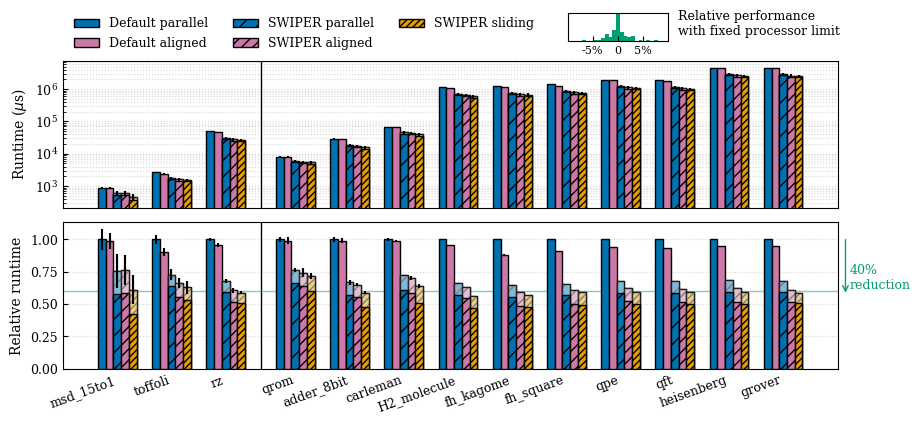

In [11]:
fig,ax = plt.subplots(2,1, figsize=(10,4), sharex=True)
d = 21

microbench = ['msd_15to1', 'toffoli', 'rz_1e-10']
# hidden_benchmarks = ['adder_n4', 'adder_n10', 'adder_n28', 'qpeinexact_5', 'qpeexact_5', 'fermi_hubbard_2_2', 'qpeinexact_10']
hidden_benchmarks = ['adder_n4', 'adder_n10', 'adder_n28', 'fermi_hubbard_2_2_Square', 'qpeexact_5']

_, result_means, result_stdevs, limited_proc_result_means, limited_proc_result_stdevs, sorted_benchmarks, sorted_keys, sorted_keys_2, colors_by_keys, limited_proc_val_differences, compare_means, relative_to_means, = plot_data(
    data_by_config=data_by_config,
    config=config,
    group_by='speculation_mode',
    group_by_2='scheduling_method',
    filter_dict={'speculation_accuracy':0.9, 'distance': d},
    relative_to={'scheduling_method':'parallel', 'speculation_mode':None},
    compare_filter_dict={'speculation_accuracy': 1.0},
    sorted_benchmarks=microbench + [b for b in benchmarks_sorted_by_volume if b not in microbench],
    x_offsets_after={
        'rz_1e-10':2.0,
    },
    ax=ax[1],
    hidden_benchmarks=hidden_benchmarks,
)
ax[1].set_ylabel('Relative runtime', fontsize=10)
ax[1].axvline(21.5, color='k', linewidth=1)
# ytick font size
plt.setp(ax[1].get_yticklabels(), fontsize=9)

handles, labels = ax[1].get_legend_handles_labels()
order = [0,1,2,3,4]
ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower left', bbox_to_anchor=(0, 1.0), ncol=3, fontsize=9, edgecolor='black', frameon=False)
# ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=5, fontsize=9, edgecolor='black', frameon=False)

ax_inset = ax[0].figure.add_axes([0.63, 0.93, 0.1, 0.07])
ax_inset.hist(limited_proc_val_differences, bins=20, color='C2')
ax_inset.tick_params(direction='in', which='both')
ax_inset.set_xlim(-0.1, 0.1)
ax_inset.set_xticks([-0.05, 0, 0.05], ['-5%', '0', '5%'], fontsize=8)
ax_inset.set_yticks([])

ax[1].grid(axis='y', linestyle=':', alpha=0.5, zorder=-10)
ax[1].axhline(0.6, color='C2', linestyle='-', linewidth=1, alpha=0.5)
ax[1].text(ax[1].get_xlim()[1]+1.5, 0.7, '40%\nreduction', fontsize=9, color='C2', va='center', ha='left')
ax[1].annotate('', (1.01, 0.9), xytext=(1.01, 0.5), xycoords='axes fraction',
            arrowprops=dict(arrowstyle="<-", color='C2'))
ax[0].grid(axis='y', linestyle=':', alpha=0.5, zorder=-10, which='both')

ax[0].text(0.74, 0.945, 'Relative performance\nwith fixed processor limit', transform=fig.transFigure, fontsize=9)

_, _, _, _, _, _, _, _, _, _, _, _, = plot_data(
    data_by_config=data_by_config,
    config=config,
    group_by='speculation_mode',
    group_by_2='scheduling_method',
    filter_dict={'distance': d},
    compare_filter_dict={'speculation_accuracy': 1.0},
    sorted_benchmarks=sorted_benchmarks,
    x_offsets_after={
        'rz_1e-10':2.0,
    },
    ax=ax[0],
    hidden_benchmarks=hidden_benchmarks,
)

plt.subplots_adjust(hspace=0.1)
ax[0].set_ylabel(r'Runtime ($\mu$s)', fontsize=10)
ax[0].axvline(21.5, color='k', linewidth=1)
ax[0].tick_params(direction='in', which='both')
ax[0].set_yscale('log')
plt.setp(ax[0].get_yticklabels(), fontsize=9)
plt.savefig('notebooks/figures/benchmarks_combined.pdf', bbox_inches='tight')
plt.savefig('notebooks/figures/benchmarks_combined.svg', bbox_inches='tight')
plt.show()

In [12]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

improvements_aligned = []
improvements_swiper_parallel = []
improvements_swiper_aligned = []
improvements_swiper_sliding = []
for benchmark in sorted_benchmarks:
    improvements_aligned.append(1 - result_means[(benchmark, None, 'aligned')] / result_means[(benchmark, None, 'parallel')])
    improvements_swiper_parallel.append(1 - result_means[(benchmark, 'separate', 'parallel')] / result_means[(benchmark, None, 'parallel')])
    improvements_swiper_aligned.append(1 - result_means[(benchmark, 'separate', 'aligned')] / result_means[(benchmark, None, 'parallel')])
    improvements_swiper_sliding.append(1 - result_means[(benchmark, 'separate', 'sliding')] / result_means[(benchmark, None, 'parallel')])

print(f'Improvements aligned: {min(improvements_aligned)*100:0.1f}% to {max(improvements_aligned)*100:0.1f}% (mean {np.mean(improvements_aligned)*100:0.1f}%)')
print(f'Improvements SWIPER parallel: {min(improvements_swiper_parallel)*100:0.1f}% to {max(improvements_swiper_parallel)*100:0.1f}% (geometric mean {geo_mean(improvements_swiper_parallel)*100:0.1f}%)')
print(f'Improvements SWIPER aligned: {min(improvements_swiper_aligned)*100:0.1f}% to {max(improvements_swiper_aligned)*100:0.1f}% (geometric mean {geo_mean(improvements_swiper_aligned)*100:0.1f}%)')
print(f'Improvements SWIPER sliding: {min(improvements_swiper_sliding)*100:0.1f}% to {max(improvements_swiper_sliding)*100:0.1f}% (geometric mean {geo_mean(improvements_swiper_sliding)*100:0.1f}%)')

# greater than 1000 Ts
improvements_aligned = []
improvements_swiper_parallel = []
improvements_swiper_aligned = []
improvements_swiper_sliding = []
for benchmark in sorted_benchmarks:
    if benchmark_info.loc[benchmark]['T count'] <= 1000:
        continue
    improvements_aligned.append(1 - result_means[(benchmark, None, 'aligned')] / result_means[(benchmark, None, 'parallel')])
    improvements_swiper_parallel.append(1 - result_means[(benchmark, 'separate', 'parallel')] / result_means[(benchmark, None, 'parallel')])
    improvements_swiper_aligned.append(1 - result_means[(benchmark, 'separate', 'aligned')] / result_means[(benchmark, None, 'parallel')])
    improvements_swiper_sliding.append(1 - result_means[(benchmark, 'separate', 'sliding')] / result_means[(benchmark, None, 'parallel')])

print('\nBenchmarks with more than 1000 Ts:')
print(f'Improvements aligned: {min(improvements_aligned)*100:0.1f}% to {max(improvements_aligned)*100:0.1f}% (geometric mean {geo_mean(improvements_aligned)*100:0.1f}%)')
print(f'Improvements SWIPER parallel: {min(improvements_swiper_parallel)*100:0.1f}% to {max(improvements_swiper_parallel)*100:0.1f}% (geometric mean {geo_mean(improvements_swiper_parallel)*100:0.1f}%)')
print(f'Improvements SWIPER aligned: {min(improvements_swiper_aligned)*100:0.1f}% to {max(improvements_swiper_aligned)*100:0.1f}% (geometric mean {geo_mean(improvements_swiper_aligned)*100:0.1f}%)')
print(f'Improvements SWIPER sliding: {min(improvements_swiper_sliding)*100:0.1f}% to {max(improvements_swiper_sliding)*100:0.1f}% (geometric mean {geo_mean(improvements_swiper_sliding)*100:0.1f}%)')

# overheads due to missed speculations
losses_swiper_parallel = []
losses_swiper_aligned = []
losses_swiper_sliding = []
for benchmark in sorted_benchmarks:
    if benchmark_info.loc[benchmark]['T count'] <= 1000:
        continue
    losses_swiper_parallel.append(1 - compare_means[(benchmark, 'separate', 'parallel')] / result_means[(benchmark, 'separate', 'parallel')])
    losses_swiper_aligned.append(1 - compare_means[(benchmark, 'separate', 'aligned')] / result_means[(benchmark, 'separate', 'parallel')])
    losses_swiper_sliding.append(1 - compare_means[(benchmark, 'separate', 'sliding')] / result_means[(benchmark, 'separate', 'parallel')])

print('\nOverheads due to missed speculations (benchmarks with at least 1000 Ts):')
print(f'Overheads SWIPER parallel: {min(losses_swiper_parallel)*100:0.1f}% to {max(losses_swiper_parallel)*100:0.1f}% (geometric mean {geo_mean(losses_swiper_parallel)*100:0.1f}%)')
print(f'Overheads SWIPER aligned: {min(losses_swiper_aligned)*100:0.1f}% to {max(losses_swiper_aligned)*100:0.1f}% (geometric mean {geo_mean(losses_swiper_aligned)*100:0.1f}%)')
print(f'Overheads SWIPER sliding: {min(losses_swiper_sliding)*100:0.1f}% to {max(losses_swiper_sliding)*100:0.1f}% (geometric mean {geo_mean(losses_swiper_sliding)*100:0.1f}%)')
print(f'Overall overheads: {min(losses_swiper_parallel + losses_swiper_aligned + losses_swiper_sliding)*100:0.1f}% to {max(losses_swiper_parallel + losses_swiper_aligned + losses_swiper_sliding)*100:0.1f}% (geometric mean {geo_mean(losses_swiper_parallel + losses_swiper_aligned + losses_swiper_sliding)*100:0.1f}%)')

Improvements aligned: 0.9% to 11.8% (mean 5.0%)
Improvements SWIPER parallel: 23.5% to 35.4% (geometric mean 30.5%)
Improvements SWIPER aligned: 23.8% to 40.6% (geometric mean 34.7%)
Improvements SWIPER sliding: 27.9% to 43.6% (geometric mean 39.2%)

Benchmarks with more than 1000 Ts:
Improvements aligned: 4.3% to 11.8% (geometric mean 6.3%)
Improvements SWIPER parallel: 31.5% to 35.4% (geometric mean 32.9%)
Improvements SWIPER aligned: 36.9% to 40.6% (geometric mean 38.4%)
Improvements SWIPER sliding: 40.4% to 43.6% (geometric mean 41.5%)

Overheads due to missed speculations (benchmarks with at least 1000 Ts):
Overheads SWIPER parallel: 12.5% to 14.5% (geometric mean 13.7%)
Overheads SWIPER aligned: 17.6% to 24.4% (geometric mean 22.9%)
Overheads SWIPER sliding: 24.9% to 28.7% (geometric mean 26.2%)
Overall overheads: 12.5% to 28.7% (geometric mean 20.2%)


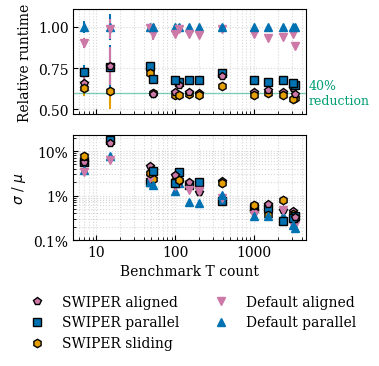

In [13]:
fig,ax = plt.subplots(2,1,figsize=(3,3), sharex=True)
markers = {
    None: {
        'parallel': '^',
        'aligned': 'v',
    },
    'separate': {
        'parallel': 's',
        'aligned': 'p',
        'sliding': 'h',
    }
}
made_labels = {key:{key2:False for key2 in set([k for _,_,k in result_means.keys() if _ == key])} for key in set([k for _,k,_ in result_means.keys()])}
for key,mean in result_means.items():
    stdev = result_stdevs[key]
    if stdev == 0:
        continue
    try:
        t_count = benchmark_info.loc[key[0], 'T count']
        relative_to = result_means[(key[0], None, 'parallel')]
        ax[0].errorbar(t_count, mean / relative_to, yerr=stdev / relative_to, marker=markers[key[1]][key[2]], linestyle='none', markeredgecolor='k' if key[1] else None, markeredgewidth=1, color=colors_by_keys[(key[2],key[1])], label=f'{to_str("speculation_mode", key[1])} {to_str("scheduling_method", key[2])}' if not made_labels[key[1]][key[2]] else None)
        made_labels[key[1]][key[2]] = True
    except KeyError as e:
        continue
# ax[0].loglog()
# handles, labels = ax[0].get_legend_handles_labels()
# order = [1,4,0,2,3]
# ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left', bbox_to_anchor=(1.0, -0.05), fontsize=10, frameon=False)
# ax[0].set_xlabel('T count')
ax[0].grid(axis='both', alpha=0.5, zorder=-10, linestyle=':', which='both')
ax[0].set_ylabel('Relative runtime')
ax[0].tick_params(direction='in', which='both')
ax[0].axhline(0.6, color='C2', linestyle='-', linewidth=1, alpha=0.5)
ax[0].text(ax[1].get_xlim()[1]*1.4, 0.6, '40%\nreduction', fontsize=9, color='C2', va='center')

xs = []
ys = []
made_labels = {key:{key2:False for key2 in set([k for _,_,k in result_means.keys() if _ == key])} for key in set([k for _,k,_ in result_means.keys()])}
for key,mean in result_means.items():
    stdev = result_stdevs[key]
    if stdev == 0:
        continue
    try:
        t_count = benchmark_info.loc[key[0], 'T count']
    except KeyError as e:
        continue
    xs.append(t_count)
    ys.append(stdev / mean)
    ax[1].errorbar(t_count, stdev / mean, marker=markers[key[1]][key[2]], linestyle='none', markeredgecolor='k' if key[1] else None, markeredgewidth=1, color=colors_by_keys[(key[2],key[1])], label=f'{to_str("speculation_mode", key[1])} {to_str("scheduling_method", key[2])}' if not made_labels[key[1]][key[2]] else None)
    made_labels[key[1]][key[2]] = True
ax[1].loglog()
# handles, labels = ax[1].get_legend_handles_labels()
# order = [1,2,0,4,3]
# ax[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
# loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10, frameon=False)
def poly(x, a, k):
    return a*x**k
result = scipy.optimize.curve_fit(poly, xs, ys)
# ax[1].plot([min(xs), max(xs)], poly(np.array([min(xs), max(xs)]), *result[0]), color='C2', linestyle='--', zorder=-10)

ax[1].set_xlabel('Benchmark T count')
ax[1].set_ylabel(r'$\sigma$ / $\mu$')
ax[1].grid(axis='both', alpha=0.5, zorder=-10, linestyle=':', which='both')
ax[1].tick_params(direction='in', which='both')
ax[1].set_xticks([10, 100, 1000], ['10', '100', '1000'])
ax[1].set_yticks([0.1, 0.01, 0.001], ['10%', '1%', '0.1%'])

handles, labels = ax[1].get_legend_handles_labels()
order = [1,0,4,2,3]
ax[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper center', bbox_to_anchor=(0.5, -0.4), fontsize=10, frameon=False, ncol=2)

plt.savefig('notebooks/figures/tcount_vs_stdev.pdf', bbox_inches='tight')
plt.savefig('notebooks/figures/tcount_vs_stdev.svg', bbox_inches='tight')
plt.show()

In [14]:
benchmark_info['t merge ratio'] = benchmark_info['T volume'] / benchmark_info['Merge volume']

In [15]:
benchmark_info[benchmark_info.index.isin(sorted_benchmarks)].sort_values('T count')

,Space footprint,Ideal time,Ideal volume,Instruction count,T count,T volume,Merge count,Merge volume,density,T instruction ratio,t merge ratio
toffoli,9.0,26.857143,83.000000,40.0,7.0,21.000000,26.0,54.000000,0.343381,0.525000,0.388889
msd_15to1,32.0,7.523810,119.000000,50.0,15.0,15.952381,20.0,87.333333,0.494264,0.900000,0.182661
qrom_15_15,153.0,136.857143,1724.285714,468.0,48.0,336.000000,355.0,1314.000000,0.082347,0.307692,0.255708
rz_1e-10,4.0,335.142857,870.285714,499.0,100.0,400.000000,250.0,300.000000,0.649190,0.601202,1.333333
adder_n18,111.0,234.714286,2354.000000,708.0,112.0,656.000000,484.0,1570.000000,0.090353,0.474576,0.417834
carleman_2_4,264.0,788.285714,13646.571429,3304.0,394.0,2830.000000,2423.0,10260.000000,0.065575,0.357748,0.275828
H2,92.0,7543.857143,39912.000000,16037.0,3084.0,23288.000000,8214.0,11208.000000,0.057507,0.576916,2.077802
fermi_hubbard_2_2_Kagome,181.0,8785.428571,51785.142857,19974.0,3340.0,23792.000000,11376.0,21984.000000,0.032566,0.501652,1.082242
fermi_hubbard_4_4_Square,225.0,10384.428571,77864.428571,25816.0,3993.0,28612.000000,15555.0,42089.000000,0.033325,0.464015,0.679798
qpeexact_10,85.0,14076.857143,124645.142857,59340.0,11378.0,64886.000000,29964.0,39190.000000,0.104172,0.575228,1.655677


In [16]:
import datetime as dt

# only want the Midway3 data for this part
runtime_directories = ['slurm/data/benchmarks2']

space_fps = []
instr_counts = []
instr_volumes = []
runtimes = []
config_idx_offset = 0
for i,directory in enumerate(runtime_directories):
    with open(f'{directory}/config.json', 'r') as f:
        dir_config = json.load(f)
    for conf_idx in range(config_idx_offset, len(dir_config) + config_idx_offset):
        if conf_idx in data_by_config:
            data = data_by_config[conf_idx]
            if not data['success']:
                continue
            benchmark = benchmark_name(dir_config[conf_idx])
            # if benchmark.startswith('rz'):
            #     continue
            with open(f'{directory}/logs/{conf_idx - config_idx_offset}.out', 'r') as f:
                try:
                    # 0:40:30.184628
                    timestr = list(f.readlines())[-1].split(' ')[-1].strip()
                    if timestr[1] == ':':
                        timestr = '0' + timestr
                    t = dt.datetime.strptime(timestr, '%H:%M:%S.%f')
                    delta = dt.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second, microseconds=t.microsecond)
                    runtimes.append(delta.total_seconds())
                
                    space_fps.append(benchmark_info.loc[benchmark, 'Space footprint'])
                    instr_counts.append(benchmark_info.loc[benchmark, 'Instruction count'])
                    instr_volumes.append(benchmark_info.loc[benchmark, 'Ideal volume'])
                except KeyError as e:
                    runtimes = runtimes[:-1]
                    continue
                except ValueError as e:
                    continue

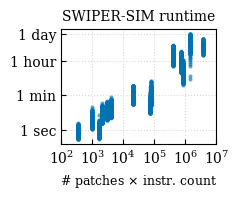

In [17]:
fig,ax = plt.subplots(figsize=(2, 1.5))
ax.plot(np.array(space_fps) * np.array(instr_counts), runtimes, marker='o', linestyle='', markersize=2, alpha=0.5)
ax.set_xlabel(r'# patches $\times$ instr. count', fontsize=9)
# ax.set_ylabel('Runtime', fontsize=9)

ax.loglog()
ax.set_xticks([10**2, 10**3, 10**4, 10**5, 10**6, 10**7])
ax.set_yticks([1, 60, 60*60, 24*60*60], ['1 sec', '1 min', '1 hour', '1 day'])
ax.grid(axis='both', linestyle=':', alpha=0.5, zorder=-10, which='both')
ax.set_title('SWIPER-SIM runtime', fontsize=10)
ax.tick_params(direction='in', which='both')
plt.savefig('notebooks/figures/simulator_runtime.svg', bbox_inches='tight')
plt.savefig('notebooks/figures/simulator_runtime.pdf', bbox_inches='tight')

## Looking at wasted computation due to missed speculations

None
None
predict
None
None


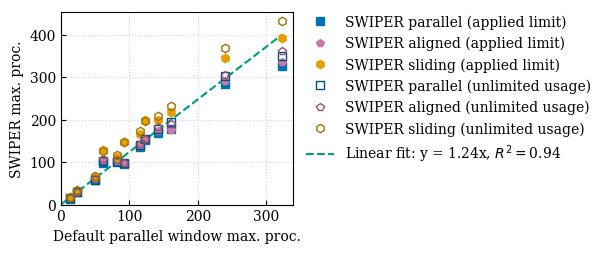

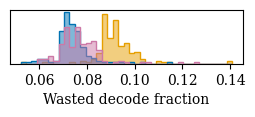

In [18]:
fig,ax = plt.subplots(figsize=(3,2.5))

parallel_procs = {}
for key, data in data_by_config.items():
    if not data['success']:
        continue
    benchmark = benchmark_name(config[key])
    procs = data['decoding_data']['max_parallel_decoders']
    group_key = config[key]['speculation_mode']
    group_key_2 = config[key]['scheduling_method']
    if ('grover_ancilla_5', 'separate', 'parallel') == (benchmark, group_key, group_key_2):
        print(config[key]['max_parallel_processes'])
    if config[key]['max_parallel_processes'] is None:
        # unlimited
        parallel_procs.setdefault((benchmark, group_key, group_key_2, False), []).append(data['decoding_data']['max_parallel_decoders'])
    else:
        parallel_procs.setdefault((benchmark, group_key, group_key_2, True), []).append(data['simulator_params']['max_parallel_processes'])

xs = []
ys = [[], [], [], [], [], []]

for i,benchmark in enumerate(sorted_benchmarks):
    init_len = len(xs)
    try:
        xs.append(np.mean(parallel_procs[(benchmark, None, 'parallel', False)]))
        ys[0].append(np.mean(parallel_procs[(benchmark, 'separate', 'parallel', True)]))
        ys[1].append(np.mean(parallel_procs[(benchmark, 'separate', 'aligned', True)]))
        ys[2].append(np.mean(parallel_procs[(benchmark, 'separate', 'sliding', True)]))
        ys[3].append(np.mean(parallel_procs[(benchmark, 'separate', 'parallel', False)]))
        ys[4].append(np.mean(parallel_procs[(benchmark, 'separate', 'aligned', False)]))
        ys[5].append(np.mean(parallel_procs[(benchmark, 'separate', 'sliding', False)]))
    except:
        xs = xs[:init_len]
        ys = [y[:init_len] for y in ys]

# for i,benchmark in enumerate(sorted_benchmarks):
ax.plot(xs, ys[0], marker=markers['separate']['parallel'], linestyle='none', color=colors_by_keys[('parallel','separate')], label=f'SWIPER parallel (applied limit)')
ax.plot(xs, ys[1], marker=markers['separate']['aligned'], linestyle='none', color=colors_by_keys[('aligned','separate')], label=f'SWIPER aligned (applied limit)')
ax.plot(xs, ys[2], marker=markers['separate']['sliding'], linestyle='none', color=colors_by_keys[('sliding','separate')], label=f'SWIPER sliding (applied limit)')
ax.plot(xs, ys[3], marker=markers['separate']['parallel'], linestyle='none', markerfacecolor='none', color=interpolate('k',colors_by_keys[('parallel','separate')],0.7), markeredgewidth=1, label=f'SWIPER parallel (unlimited usage)')
ax.plot(xs, ys[4], marker=markers['separate']['aligned'], linestyle='none', markerfacecolor='none', color=interpolate('k',colors_by_keys[('aligned','separate')],0.7), markeredgewidth=1, label=f'SWIPER aligned (unlimited usage)')
ax.plot(xs, ys[5], marker=markers['separate']['sliding'], linestyle='none', markerfacecolor='none', color=interpolate('k',colors_by_keys[('sliding','separate')],0.7), markeredgewidth=1, label=f'SWIPER sliding (unlimited usage)')

all_data = np.hstack(ys)
all_xs = np.hstack([xs for y in ys])
def fixed_line(x, slope):
    return slope*x
result = scipy.optimize.curve_fit(fixed_line, all_xs, all_data)
r2 = 1 - np.sum((all_data - fixed_line(all_xs, *result[0]))**2) / np.sum((all_data - np.mean(all_data))**2)
ax.plot([0, max(xs)], [0, max(xs)*result[0][0]], color='C2', linestyle='--', label=f'Linear fit: y = {result[0][0]:0.2f}x' + r', $R^2=$' + f'{r2:0.2f}', zorder=-1)

# ax.plot(xs, np.array(ys[0])+10+np.random.random()*5, marker=markers['separate']['parallel'], linestyle='none', color=colors_by_keys['separate']['parallel'], label=f'SWIPER parallel')
# ax.plot(xs, np.array(ys[1])+10+np.random.random()*5, marker=markers['separate']['aligned'], linestyle='none', color=colors_by_keys['separate']['aligned'], label=f'SWIPER aligned')
# ax.plot(xs, np.array(ys[2])+10+np.random.random()*5, marker=markers['separate']['sliding'], linestyle='none', color=colors_by_keys['separate']['sliding'], label=f'SWIPER sliding')
ax.set_xlim(0)
ax.set_ylim(0)
# ax.loglog()
# ax.set_title('Max. parallel processes')
ax.grid(axis='both', linestyle=':', alpha=0.5, zorder=-10, which='both')
ax.set_xlabel('Default parallel window max. proc.')
ax.set_ylabel('SWIPER max. proc.')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), fontsize=10, frameon=False)
ax.tick_params(direction='in', which='both')
plt.savefig('notebooks/figures/max_parallel_processes.svg', bbox_inches='tight')
plt.show()

fig,ax = plt.subplots(figsize=(3, 0.7))

wasted_fracs = {
    'sliding': [],
    'aligned': [],
    'parallel': [],
}

for key, data in data_by_config.items():
    if not (
        data['success']
        and data['simulator_params']['speculation_mode'] == 'separate'
        and data['simulator_params']['speculation_accuracy'] == 0.9
        and data['simulator_params']['distance'] == 21
        and data['simulator_params']['max_parallel_processes'] is None
    ):
        continue
    decode_vol = data['decoding_data']['decode_process_volume']
    wasted_vol = data['decoding_data']['wasted_decode_volume']
    wasted_fracs[data['simulator_params']['scheduling_method']].append(wasted_vol / decode_vol)

bins = np.linspace(min(min(wasted_fracs['sliding']), min(wasted_fracs['aligned']), min(wasted_fracs['parallel'])), max(max(wasted_fracs['sliding']), max(wasted_fracs['aligned']), max(wasted_fracs['parallel'])), 40)
plt.hist(wasted_fracs['sliding'], bins=bins, zorder=5, color='C3', alpha=0.5)
plt.hist(wasted_fracs['sliding'], bins=bins, zorder=5, color='C3', histtype='step')
plt.hist(wasted_fracs['parallel'], bins=bins, zorder=5, color='C0', alpha=0.5)
plt.hist(wasted_fracs['parallel'], bins=bins, zorder=5, color='C0', histtype='step')
plt.hist(wasted_fracs['aligned'], bins=bins, zorder=5, color='C1', alpha=0.5)
plt.hist(wasted_fracs['aligned'], bins=bins, zorder=5, color='C1', histtype='step')
plt.xlabel('Wasted decode fraction')
plt.yticks([])
plt.grid(axis='y', linestyle=':', alpha=0.5, zorder=-10)
plt.savefig('notebooks/figures/wasted_decode_volume.svg', bbox_inches='tight')
plt.show()

# Comparing against other code distances

In [19]:
fig,ax = plt.subplots()

_, d15_means, d15_stdevs, _, _, _, _, _, _, _, _, d15_relative_to_means = plot_data(
    data_by_config=data_by_config,
    config=config,
    group_by='speculation_mode',
    group_by_2='scheduling_method',
    filter_dict={'speculation_accuracy':0.9, 'distance': 15},
    relative_to={'scheduling_method':'parallel', 'speculation_mode':None},
    sorted_benchmarks=microbench + [b for b in benchmarks_sorted_by_volume if b not in microbench],
    ax=ax,
    hidden_benchmarks=hidden_benchmarks,
)

_, d27_means, d27_stdevs, _, _, _, _, _, _, _, _, d27_relative_to_means = plot_data(
    data_by_config=data_by_config,
    config=config,
    group_by='speculation_mode',
    group_by_2='scheduling_method',
    filter_dict={'speculation_accuracy':0.9, 'distance': 27},
    relative_to={'scheduling_method':'parallel', 'speculation_mode':None},
    sorted_benchmarks=microbench + [b for b in benchmarks_sorted_by_volume if b not in microbench],
    ax=ax,
    hidden_benchmarks=hidden_benchmarks,
)

plt.close()

Removing memory_10000 (only 0 data points)
Removing random_t_1000_200_0 (only 0 data points)
Removing random_t_10000_200_0 (only 0 data points)
Removing regular_t_1000_0 (only 0 data points)
1
2
msd_15to1 None parallel: 1.0 +- 0.038869257950530034
msd_15to1 None aligned: 1.0391904914873111 +- 0.09296090066063617
msd_15to1 separate parallel: 0.849983938323161 +- 0.09340331176555733
msd_15to1 separate aligned: 0.765820751686476 +- 0.1267729339869768
msd_15to1 separate sliding: 0.686797301638291 +- 0.060742875015347315
toffoli None parallel: 1.0 +- 0.04126622532150393
toffoli None aligned: 0.8508958665957068 +- 0.032413750250868345
toffoli separate parallel: 0.7963455738868191 +- 0.04596628435685038
toffoli separate aligned: 0.6524747205960617 +- 0.03684870542440396
toffoli separate sliding: 0.6543374135178286 +- 0.039128617477464336
rz_1e-10 None parallel: 1.0 +- 0.013014496641816682
rz_1e-10 None aligned: 0.8840429019238256 +- 0.01459013239838066
rz_1e-10 separate parallel: 0.7400940400

heisenberg_3 12833.0
grover_ancilla_5 13577.0
grover_ancilla_5 13577.0
grover_ancilla_5 13577.0
fermi_hubbard_4_4_Square 3993.0
qpeexact_10 11378.0
heisenberg_3 12833.0
qpeexact_10 11378.0
fermi_hubbard_4_4_Square 3993.0
qpeexact_10 11378.0
fermi_hubbard_4_4_Square 3993.0
heisenberg_3 12833.0
carleman_2_4 394.0
qrom_15_15 48.0
qrom_15_15 48.0
H2 3084.0
toffoli 7.0
toffoli 7.0
rz_1e-10 100.0
adder_n18 112.0
rz_1e-10 100.0
H2 3084.0
qrom_15_15 48.0
carleman_2_4 394.0
msd_15to1 15.0
adder_n18 112.0
carleman_2_4 394.0
rz_1e-10 100.0
H2 3084.0
toffoli 7.0
msd_15to1 15.0
adder_n18 112.0
msd_15to1 15.0


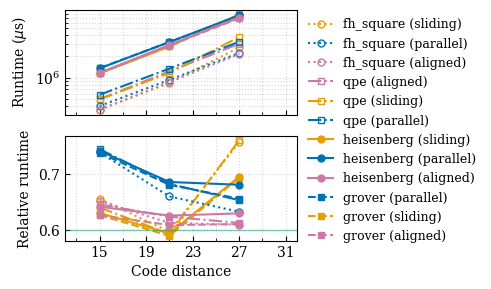

In [20]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(2,1,figsize=(3,3), sharex=True)

markers = ['o', 's', 'o', 's']
mkfcnone = [2,3]
linestyles = ['-', '--', ':', '-.']
colors = {
    'parallel': 'C0',
    'aligned': 'C1',
    'sliding': 'C3',
}

seen_benchmarks = []

benchmark_names = []
t_counts = []
d15_vals = []
d21_vals = []
d27_vals = []
for key,mean in result_means.items():
    if key in d15_means and key in d27_means and key[1] == 'separate':
        if key[0] in hidden_benchmarks:
            continue
        try:
            t_count = benchmark_info.loc[key[0], 'T count']
            d15_val_relative = d15_means[key] / d15_relative_to_means[key]
            d21_val_relative = mean / relative_to_means[key]
            d27_val_relative = d27_means[key] / d27_relative_to_means[key]
            d15_val = d15_means[key]
            d21_val = mean
            d27_val = d27_means[key]
            t_count = float(benchmark_info.loc[key[0], 'T count'])
        except KeyError as e:
            continue
        print(key[0], t_count)
        if t_count > 3500:
            if key[0] in seen_benchmarks:
                b_idx = seen_benchmarks.index(key[0])
            else:
                seen_benchmarks.append(key[0])
                b_idx = len(seen_benchmarks) - 1
            
            ax[0].plot([15, 21, 27], [d15_val, d21_val, d27_val], marker=markers[b_idx], markersize=5, markerfacecolor=('none' if b_idx in mkfcnone else colors[key[2]]), color=colors[key[2]], label=f'{key[0]} ({key[2]})', linestyle=linestyles[b_idx])
            ax[1].plot([15, 21, 27], [d15_val_relative, d21_val_relative, d27_val_relative], marker=markers[b_idx], markersize=5, markerfacecolor=('none' if b_idx in mkfcnone else colors[key[2]]), color=colors[key[2]], linestyle=linestyles[b_idx])

# sort keys by sorted_benchmarks
handles, labels = ax[0].get_legend_handles_labels()
order = np.argsort([sorted_benchmarks.index(label.split(' ')[0]) for label in labels])

# replace benchmark name with renamed name, if applicable
labels = [rename_benchmarks[label.split(' ')[0]]+' '+label.split(' ')[1] if label.split(' ')[0] in rename_benchmarks else label for label in labels]

ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='center left', bbox_to_anchor=(1.0, -0.15), fontsize=9, frameon=False, ncol=1)
# ax[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper center', bbox_to_anchor=(0.5, -0.45), fontsize=9, frameon=False, ncol=2)

# legend on side
# ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=9, frameon=False)
ax[0].set_yscale('log')
ax[0].set_ylabel(r'Runtime ($\mu$s)')
ax[0].grid(axis='both', linestyle=':', alpha=0.5, zorder=-10, which='both')
ax[0].tick_params(direction='in', which='both')

ax[1].set_xticks(list(range(15, 33, 4)))
ax[1].xaxis.set_minor_locator(MultipleLocator(2, 1))
ax[1].set_xlim(12, 32)
ax[1].set_xlabel('Code distance')
ax[1].set_ylabel('Relative runtime')
ax[1].grid(axis='both', linestyle=':', alpha=0.5, zorder=-10, which='both')
ax[1].tick_params(direction='in', which='both')
ax[1].axhline(0.6, color='C2', linestyle='-', linewidth=1, alpha=0.5)
# ax[0].text(ax[1].get_xlim()[1]*1.4, 0.6, '40%\nreduction', fontsize=9, color='C2', va='center')

plt.savefig('notebooks/figures/distance_vs_runtime.pdf', bbox_inches='tight')
plt.savefig('notebooks/figures/distance_vs_runtime.svg', bbox_inches='tight')
plt.show()